# Visualizing life expectancy and fertility

<span style="font-family: 'Arial'; color: blue; font-size: x-large;">Final Project</span>

### <span style="font-family: 'Times New Roman'; color: blue;">Institution: University of Amsterdam</span>
### <span style="font-family: 'Times New Roman'; color: blue;">Course: Data Processing</span>
### <span style="font-family: 'Times New Roman'; color: blue;">Student: Harit Khelifi (13765531)</span>

#### Intro:

In the realm of global health and demographics, understanding the dynamics between life expectancy and fertility rates over time can provide valuable insights into societal progress and development. This project aims to explore and visualize the changes in life expectancy and fertility rates across 244 countries from 1964 to 2013, utilizing data from Gapminder.org.

#### Research Question:

The central research question driving this project is: “How did life expectancy and fertility change between 1964 - 2013 for different countries and continents?”

#### Data:

The dataset contains information on the average life expectancy and total fertility (number of children per woman) per capita for each of the 244 countries over the specified time period (1964-2013).


#### Description:

Because of all the progress in medicine and in society since the 1960s, it could be interesting to see how these advancements affected people's life expectancy and total fertility. It is my goal to create interactive plots that help us visualize how the life expectancy and total fertility have changed over time. By doing this I hope to uncover interesting information about how people's life expectancies and fertility rates have transformed over time.

#### Smaller Research Questions:

Did the differences in how long people live and how many children they have change over the years?

Which parts of the world improved the most during this time?

Did any countries see a decrease in how long people live, and if yes, why?

Can we create a simple model to predict life expectancy?

#### Resources:

In this project the library Bokeh is used to make the interactive plots. Other libraries that are used can be found under: "Import necassray libraries".

### Import necessary libraries

In [23]:
# import necessary libraries
from bokeh.models import HoverTool, ColorBar, Slider, CustomJS, ColumnDataSource, Select
from bokeh.palettes import Viridis256, Category10_10
from bokeh.transform import linear_cmap
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, gridplot, row  # Include 'row' here
import pandas as pd
from ipywidgets import interact, widgets, interactive_output
from IPython.display import display
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans

### Loading the data

In [29]:
# read all the data files
df = pd.read_csv('gapminder.csv')

# display the data
display(df)

Country  Year  lifeExp         pop  Fertility  \
0      Afghanistan  1964   33.639  10474903.0      7.671   
1      Afghanistan  1965   34.152  10697983.0      7.671   
2      Afghanistan  1966   34.662  10927724.0      7.671   
3      Afghanistan  1967   35.170  11163656.0      7.671   
4      Afghanistan  1968   35.674  11411022.0      7.671   
...            ...   ...      ...         ...        ...   
12195        Åland  2009      NaN         NaN        NaN   
12196        Åland  2010      NaN     26923.0        NaN   
12197        Åland  2011      NaN         NaN        NaN   
12198        Åland  2012      NaN         NaN        NaN   
12199        Åland  2013      NaN         NaN        NaN   

                      Region  ID  
0                 South Asia  AF  
1                 South Asia  AF  
2                 South Asia  AF  
3                 South Asia  AF  
4                 South Asia  AF  
...                      ...  ..  
12195  Europe & Central Asia  AX  
12196  Europe & Central Asia  AX  
12197  Europe & Central Asia  AX  
12198  Europe & Central Asia  AX  
12199  Europe & Central Asia  AX  

[12200 rows x 7 columns]

We notice that there are some NaN's this is important to keep in mind when we are going to plot.

In [30]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

### Visualizing the data PART 1

In [31]:
# read the data
df = pd.read_csv('gapminder.csv')

# create a Bokeh figure with specified axis ranges
p = figure(title="Life Expectancy vs Fertility", x_axis_label='Fertility', y_axis_label='Life Expectancy',
           x_range=(0, 10), y_range=(0, 90))

# define a color palette for continents
palette = Category10_10

# add a new column 'Color' based on the continent
df['Color'] = df['Region'].astype('category').cat.codes.map(lambda x: palette[x])

# scatter plot with colored points for each continent
scatter = p.circle(x='Fertility', y='lifeExp', size=6, source=ColumnDataSource(df), color='Color', alpha=0.6, legend_field='Region')

# set legend location to bottom left
p.legend.location = 'bottom_left'

# hover tool
hover = HoverTool()
hover.tooltips = [("Country", "@Country"), ("Year", "@Year"), ("Population", "@pop{0,0}M"), ("Region", "@Region")]
p.add_tools(hover)

# create a Select widget for choosing the continent
continent_select = Select(title="Select Continent:", value="All Continents", options=["All Continents"] + df['Region'].unique().tolist())

# create a callback to update the data source based on the selected continent
callback = CustomJS(args=dict(source=ColumnDataSource(df), scatter=scatter, continent_select=continent_select), code="""
    var data = source.data;
    var selected_continent = continent_select.value;
    var new_data = {'Fertility': [], 'lifeExp': [], 'Color': [], 'Country': [], 'Region': [], 'Year': [], 'pop': []};
    
    for (var i = 0; i < data['Fertility'].length; i++) {
        if (selected_continent === 'All Continents' || data['Region'][i] === selected_continent) {
            new_data['Fertility'].push(data['Fertility'][i]);
            new_data['lifeExp'].push(data['lifeExp'][i]);
            new_data['Color'].push(data['Color'][i]);
            new_data['Country'].push(data['Country'][i]);
            new_data['Region'].push(data['Region'][i]);
            new_data['Year'].push(data['Year'][i]);
            new_data['pop'].push(data['pop'][i]);
        }
    }
    
    scatter.data_source.data = new_data;
""")

# attach the callback to the Select widget
continent_select.js_on_change('value', callback)

# show the plot with the Select widget
show(column(p, continent_select))

In [32]:
# read the data
df = pd.read_csv('gapminder.csv')

# define a color palette for continents
palette = Category10_10

# create a list to store individual plots
plots = []

# loop through each continent
for continent in df['Region'].unique():
    
    # create a subset of the data for the current continent
    subset = df[df['Region'] == continent]
    
    # create a Bokeh figure for the current continent
    p = figure(title=f"{continent}", x_axis_label='Fertility', y_axis_label='Life Expectancy')
    
    # create a linear color map based on the year
    color_mapper = linear_cmap(field_name='Year', palette=Viridis256, low=min(df['Year']), high=max(df['Year']))
    
    # add colored points for each country in the continent
    scatter = p.circle(x='Fertility', y='lifeExp', size=8, source=subset, color=color_mapper, alpha=0.6)
    
    # hover tool
    hover = HoverTool()
    hover.tooltips = [("Country", "@Country"), ("Year", "@Year"), ("Population", "@pop{0,0}M"), ("Region", "@Region")]
    p.add_tools(hover)
    
    # add the plot to the list
    plots.append(p)

# arrange plots in a 3x2 grid
grid = gridplot(plots, ncols=3, width=300, height=300)

# show the grid of plots
show(grid)

In [34]:
# read the data
df = pd.read_csv('gapminder.csv')

# create a list of continent options including "All Continents"
continent_options = ["All Continents"] + df['Region'].unique().tolist()

# create a Select widget for choosing the continent
continent_select = Select(title="Select Continent:", value=continent_options[0], options=continent_options)

# create a Bokeh figure with adjusted plot_width and plot_height
p = figure(x_axis_label='Fertility', y_axis_label='Life Expectancy', title="All Continents",
           width=600, height=400, x_range=(0, 10), y_range=(0, 85))

# initialize data for all continents
df_all_continents = df

# create a linear color map based on the year
color_mapper = linear_cmap(field_name='Year', palette=Viridis256, low=min(df_all_continents['Year']), high=max(df_all_continents['Year']))

# add colored points for each country
scatter = p.circle(x='Fertility', y='lifeExp', size=10, source=ColumnDataSource(df_all_continents), color=color_mapper, alpha=0.6)

# hover tool
hover = HoverTool()
hover.tooltips = [("Country", "@Country"), ("Year", "@Year"), ("Population", "@pop{0,0}M"), ("Region", "@Region")]
p.add_tools(hover)

# add a slider for selecting the year
slider = Slider(start=min(df_all_continents['Year']), end=max(df_all_continents['Year']),
                value=min(df_all_continents['Year']), step=1, title="Select Year")

source_original = ColumnDataSource(df)

# create a callback to update the data source based on the selected year and continent
callback = CustomJS(args=dict(source=scatter.data_source, slider=slider,
                              source_original=source_original.data,
                              continent_select=continent_select, plot=p), code="""
    var data = source_original;
    var year = slider.value;
    var selected_continent = continent_select.value;
    var new_data = {'Country': [], 'Year': [], 'lifeExp': [], 'pop': [], 'Fertility': [], 'Region': [], 'ID': []};

    for (var i = 0; i < data['Year'].length; i++) {
        if ((selected_continent == 'All Continents' || data['Region'][i] == selected_continent) && data['Year'][i] == year) {
            new_data['Country'].push(data['Country'][i]);
            new_data['Year'].push(data['Year'][i]);
            new_data['lifeExp'].push(data['lifeExp'][i]);
            new_data['pop'].push(data['pop'][i]);
            new_data['Fertility'].push(data['Fertility'][i]);
            new_data['Region'].push(data['Region'][i]);
            new_data['ID'].push(data['ID'][i]);
        }
    }

    source.data = new_data;
    plot.title.text = (selected_continent == 'All Continents') ? "All Continents" : selected_continent;
""")

# attach the callback to the slider
slider.js_on_change('value', callback)

# attach the callback to the continent select
continent_select.js_on_change('value', callback)

# show the grid of plots
show(column(p, continent_select, slider))

### Visualizing the data PART 2

In [36]:
# read the data
df = pd.read_csv('gapminder.csv')

def plot_std_dev(selected_continent='All Continents'):
    
    # filter data based on selected continent
    if selected_continent == 'All Continents':
        df_filtered = df
    else:
        df_filtered = df[df['Region'] == selected_continent]

    # calculate standard deviation for life expectancy and fertility for each year
    std_life_exp = df_filtered.groupby('Year')['lifeExp'].std()
    std_fertility = df_filtered.groupby('Year')['Fertility'].std()

    # calculate average life expectancy and fertility for each year
    avg_life_exp = df_filtered.groupby('Year')['lifeExp'].mean()
    avg_fertility = df_filtered.groupby('Year')['Fertility'].mean()

    # plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(std_life_exp.index, std_life_exp, label='Life Expectancy (Std Dev)')
    plt.plot(std_fertility.index, std_fertility, label='Fertility (Std Dev)')
    plt.plot(avg_life_exp.index, avg_life_exp, label='Life Expectancy (Avg)', linestyle='--')
    plt.plot(avg_fertility.index, avg_fertility, label='Fertility (Avg)', linestyle='--')
    plt.title(f'Standard Deviation and Average Over Years ({selected_continent})')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# create a dropdown widget for selecting the continent
continent_dropdown = widgets.Dropdown(
    options=['All Continents'] + df['Region'].unique().tolist(),
    value='All Continents',
    description='Select Continent:'
)

# use interactive_output to create a dynamic output without unwanted text
output = interactive_output(plot_std_dev, {'selected_continent': continent_dropdown})

# display both the dropdown and the output
display(output, continent_dropdown)

Output()

Dropdown(description='Select Continent:', options=('All Continents', 'South Asia', 'Europe & Central Asia', 'M…

### Visualizing the data PART 3

In [9]:
# read the data
df = pd.read_csv('gapminder.csv')

# group data by Region and calculate the average life expectancy and fertility for each year
avg_data_by_region = df.groupby(['Region', 'Year']).agg({'lifeExp': 'mean', 'Fertility': 'mean'}).reset_index()

# create a color palette for regions
palette = Category10_10

# create Bokeh figures for life expectancy and fertility
life_exp_plot = figure(title='Average Life Expectancy by Region Over Time', x_axis_label='Year', y_axis_label='Average Life Expectancy', width=400, height=800)
fertility_plot = figure(title='Average Fertility by Region Over Time', x_axis_label='Year', y_axis_label='Average Fertility', width=400, height=800)

# plot each region in a different color
for i, region in enumerate(df['Region'].unique()):
    region_data = avg_data_by_region[avg_data_by_region['Region'] == region]
    
    life_exp_line = life_exp_plot.line(x='Year', y='lifeExp', source=ColumnDataSource(region_data), line_width=2, line_color=palette[i], legend_label=region)
    fertility_line = fertility_plot.line(x='Year', y='Fertility', source=ColumnDataSource(region_data), line_width=2, line_color=palette[i], legend_label=region)

# add hover tools
life_exp_hover = HoverTool(renderers=[life_exp_line])
life_exp_hover.tooltips = [("Region", "@Region"), ("Year", "@Year"), ("Avg Life Expectancy", "@lifeExp")]
life_exp_plot.add_tools(life_exp_hover)

fertility_hover = HoverTool(renderers=[fertility_line])
fertility_hover.tooltips = [("Region", "@Region"), ("Year", "@Year"), ("Avg Fertility", "@Fertility")]
fertility_plot.add_tools(fertility_hover)

# customize legends and layouts
life_exp_plot.legend.title = 'Region'
life_exp_plot.legend.location = 'bottom_right'
life_exp_plot.legend.label_text_font_size = '10pt'

fertility_plot.legend.title = 'Region'
fertility_plot.legend.location = 'top_right'
fertility_plot.legend.label_text_font_size = '10pt'

# show the plots side by side
show(row(life_exp_plot, fertility_plot, sizing_mode="stretch_height"))


### Visualizing the data PART 4

In [38]:
# read the data
df = pd.read_csv('gapminder.csv')

# sort the data by country and year
df.sort_values(['Country', 'Year'], inplace=True)

# calculate the change in life expectancy compared to the previous year
df['LifeExpChange'] = df.groupby('Country')['lifeExp'].diff()

# function to plot the count of countries with a decrease in life expectancy each year
def plot_decrease_count(selected_region='All Regions'):
    
    # filter data based on the selected region
    if selected_region == 'All Regions':
        decrease_df = df[df['LifeExpChange'] < 0]
    else:
        decrease_df = df[(df['LifeExpChange'] < 0) & (df['Region'] == selected_region)]

    # count the number of countries with a decrease in life expectancy each year
    count_by_year = decrease_df.groupby('Year')['Country'].nunique()

    # include years with no decrease in life expectancy and set count to 0
    all_years = df['Year'].unique()
    count_by_year = count_by_year.reindex(all_years, fill_value=0)

    # plot the count over time
    plt.plot(count_by_year.index, count_by_year.values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Number of Countries with Decrease in Life Expectancy')
    plt.title(f'Number of Countries with Decrease in Life Expectancy Over Time ({selected_region})')
    plt.show()

# create a dropdown widget for selecting the region
region_dropdown = widgets.Dropdown(
    options=['All Regions'] + df['Region'].unique().tolist(),
    value='All Regions',
    description='Select Region:'
)

# use interact to dynamically display the plot based on the dropdown value
interact(plot_decrease_count, selected_region=region_dropdown)

interactive(children=(Dropdown(description='Select Region:', options=('All Regions', 'South Asia', 'Europe & C…

<function __main__.plot_decrease_count(selected_region='All Regions')>

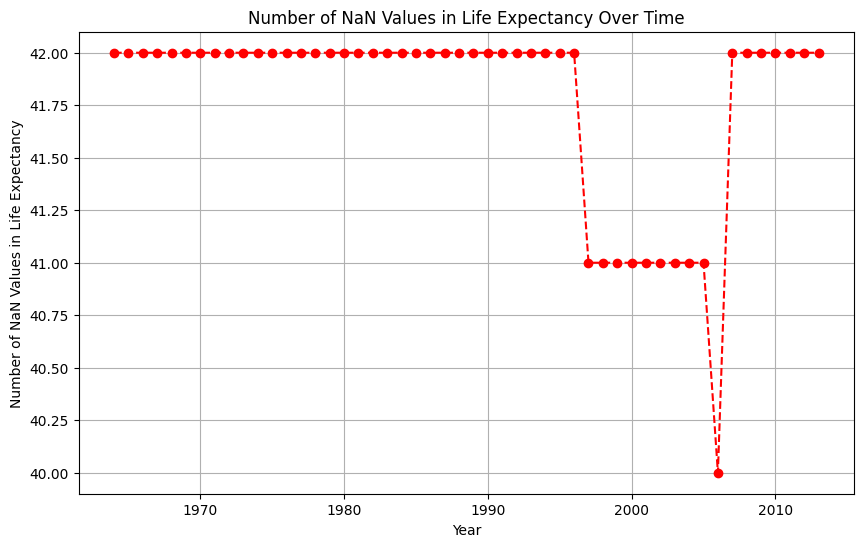

In [39]:
# read the data
df = pd.read_csv('gapminder.csv')

# sort the data by country and year
df.sort_values(['Country', 'Year'], inplace=True)

# calculate the count of NaN values in life expectancy for each year
nan_count_by_year = df.groupby('Year')['lifeExp'].apply(lambda x: x.isna().sum())

# plot the count of NaN values over time
plt.figure(figsize=(10, 6))
plt.plot(nan_count_by_year.index, nan_count_by_year.values, marker='o', linestyle='--', color='red')
plt.xlabel('Year')
plt.ylabel('Number of NaN Values in Life Expectancy')
plt.title('Number of NaN Values in Life Expectancy Over Time')
plt.grid(True)
plt.show()

### Visualizing the data PART 5

In [44]:
# read the data
df = pd.read_csv('gapminder.csv')

# drop any missing values
df_cleaned = df.dropna(subset=['lifeExp', 'Fertility'])

# defining the independent variable (X) and dependent variable (y)
X = df_cleaned[['Fertility']]  # Predictor
y = df_cleaned['lifeExp']  # Response

# adding a constant to the model (intercept)
X = sm.add_constant(X)

# fitting the OLS model
model = sm.OLS(y, X).fit()

# printing the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeExp   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                 2.275e+04
Date:                Thu, 30 May 2024   Prob (F-statistic):               0.00
Time:                        23:10:50   Log-Likelihood:                -32701.
No. Observations:               10100   AIC:                         6.541e+04
Df Residuals:                   10098   BIC:                         6.542e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.5691      0.137    601.864      0.000      82.300      82.838
Fertility     -4.5937      0.030   -150.816      0.000      -4.653      -4.534
==============================================================================
Omnibus:                      945.795   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2801.787
Skew:                          -0.501   Prob(JB):                         0.00
Kurtosis:                       5.378   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# specified regions for the dummy variable to be set to 1
specified_regions = ["South Asia", "Europe & Central Asia", "America"]
 
# create a new column 'Region_Dummy' where value is 1 if 'Region' is in the specified regions, else 0
df['Region_Dummy'] = df['Region'].apply(lambda x: 1 if x in specified_regions else 0)

# drop any missing values
df_clean = df.dropna(subset=['Year', 'lifeExp', 'Fertility'])

# reshaping 'Year' for KMeans, which expects a 2D array
years_reshaped = df_clean['Year'].values.reshape(-1, 1)

# perform KMeans clustering with 3 clusters on the reshaped year data
kmeans = KMeans(n_clusters=3, random_state=0).fit(years_reshaped)

# 64-78, 79-95, 96-13
# assign the cluster labels back to the DataFrame
df_clean['Year_Cluster'] = kmeans.labels_

# preparing data for the OLS regression
X = df_clean[['Fertility', 'Year_Cluster', 'Region_Dummy']]
y = df_clean['lifeExp']

# adding a constant to the model for the intercept
X = sm.add_constant(X)

# fitting the OLS model with the specified predictors
model_numeric_clusters = sm.OLS(y, X).fit()

# printing the summary of the model
model_summary_numeric_clusters = model_numeric_clusters.summary()
model_summary_numeric_clusters

C:\Users\Harit\AppData\Local\Temp\ipykernel_8808\1430378897.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Year_Cluster'] = kmeans.labels_


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeExp   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     7695.
Date:                Thu, 30 May 2024   Prob (F-statistic):               0.00
Time:                        23:16:11   Log-Likelihood:                -32648.
No. Observations:               10100   AIC:                         6.530e+04
Df Residuals:                   10096   BIC:                         6.533e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           81.3205      0.200    406.955      0.000      80.929      81.712
Fertility       -4.3241      0.040   -107.636      0.000      -4.403      -4.245
Year_Cluster    -0.5545      0.085     -6.516      0.000      -0.721      -0.388
Region_Dummy     1.3948      0.149      9.387      0.000       1.104       1.686
==============================================================================
Omnibus:                      845.632   Durbin-Watson:                   0.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2474.321
Skew:                          -0.449   Prob(JB):                         0.00
Kurtosis:                       5.252   Cond. No.                         18.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""